In [1]:
! conda install -y hvplot

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - hvplot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bokeh-2.2.0                |   py37hc8dfbb8_0         7.1 MB  conda-forge
    colorcet-2.0.1             |             py_0         1.5 MB  conda-forge
    conda-4.8.4                |   py37hc8dfbb8_2         3.1 MB  conda-forge
    holoviews-1.13.3           |     pyh9f0ad1d_0         3.4 MB  conda-forge
    hvplot-0.6.0               |     pyh9f0ad1d_0         2.9 MB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    panel-0.9.7                |             py_0         921 KB  conda-forge
    param-1.9.3                |             py_0          60 KB  conda-forge
    pyct-0.4.6                 |             py_0           3 KB  conda-forge
    pyct-core-0.4.6            

In [2]:
#importing Libs
import os
import glob
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas

# Images and Annotaions
excerpt-from-openimages-2020-train Data set is from another dataset, but this dataset has more number of objects per images and more classes of objects

Reading the data and shwoing few images containing boxes and segments masks along with labels.

In [3]:
data_dir = Path('../input/excerpt-from-openimages-2020-train')
im_list = sorted(data_dir.glob('train_00_part/*.jpg'))
mask_list = sorted(data_dir.glob('train-masks-f/*.png'))
boxes_df = pd.read_csv(data_dir/'oidv6-train-annotations-bbox.csv')

names_ = ['LabelName', 'Label']
labels =  pd.read_csv(data_dir/'class-descriptions-boxable.csv', names=names_)

im_ids = [im.stem for im in im_list]
cols = ['ImageID', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax']
boxes_df = boxes_df.loc[boxes_df.ImageID.isin(im_ids), cols] \
                   .merge(labels, how='left', on='LabelName')
boxes_df

ImageID   LabelName      XMin      YMin      XMax      YMax  \
0     fcee8503fd335f25  /m/03bt1vf  0.468125  0.425833  0.574375  0.745000   
1     fcee8503fd335f25   /m/0c9ph5  0.757500  0.288333  0.840625  0.417500   
2     fcee8503fd335f25  /m/03bt1vf  0.000000  0.433333  0.050000  0.778333   
3     fcee8503fd335f25  /m/03bt1vf  0.023125  0.428333  0.098125  0.749167   
4     fcee8503fd335f25  /m/03bt1vf  0.094375  0.399167  0.158750  0.550833   
...                ...         ...       ...       ...       ...       ...   
2373  fefee3d235b1c20b    /m/07j7r  0.370313  0.608333  0.507812  0.858333   
2374  fefee3d235b1c20b    /m/07j7r  0.509375  0.681250  0.606250  0.856250   
2375  fefee3d235b1c20b    /m/07j7r  0.601562  0.675000  0.723437  0.854167   
2376  fefee3d235b1c20b    /m/07j7r  0.731250  0.670833  0.865625  0.858333   
2377  fefee3d235b1c20b    /m/07j7r  0.870313  0.660417  0.998438  0.835417   

       Label  
0      Woman  
1     Flower  
2      Woman  
3      Woman  
4      Woman  
...      ...  
2373    Tree  
2374    Tree  
2375    Tree  
2376    Tree  
2377    Tree  

[2378 rows x 7 columns]

Below we are using opencv to draw rectagle and text on the objects

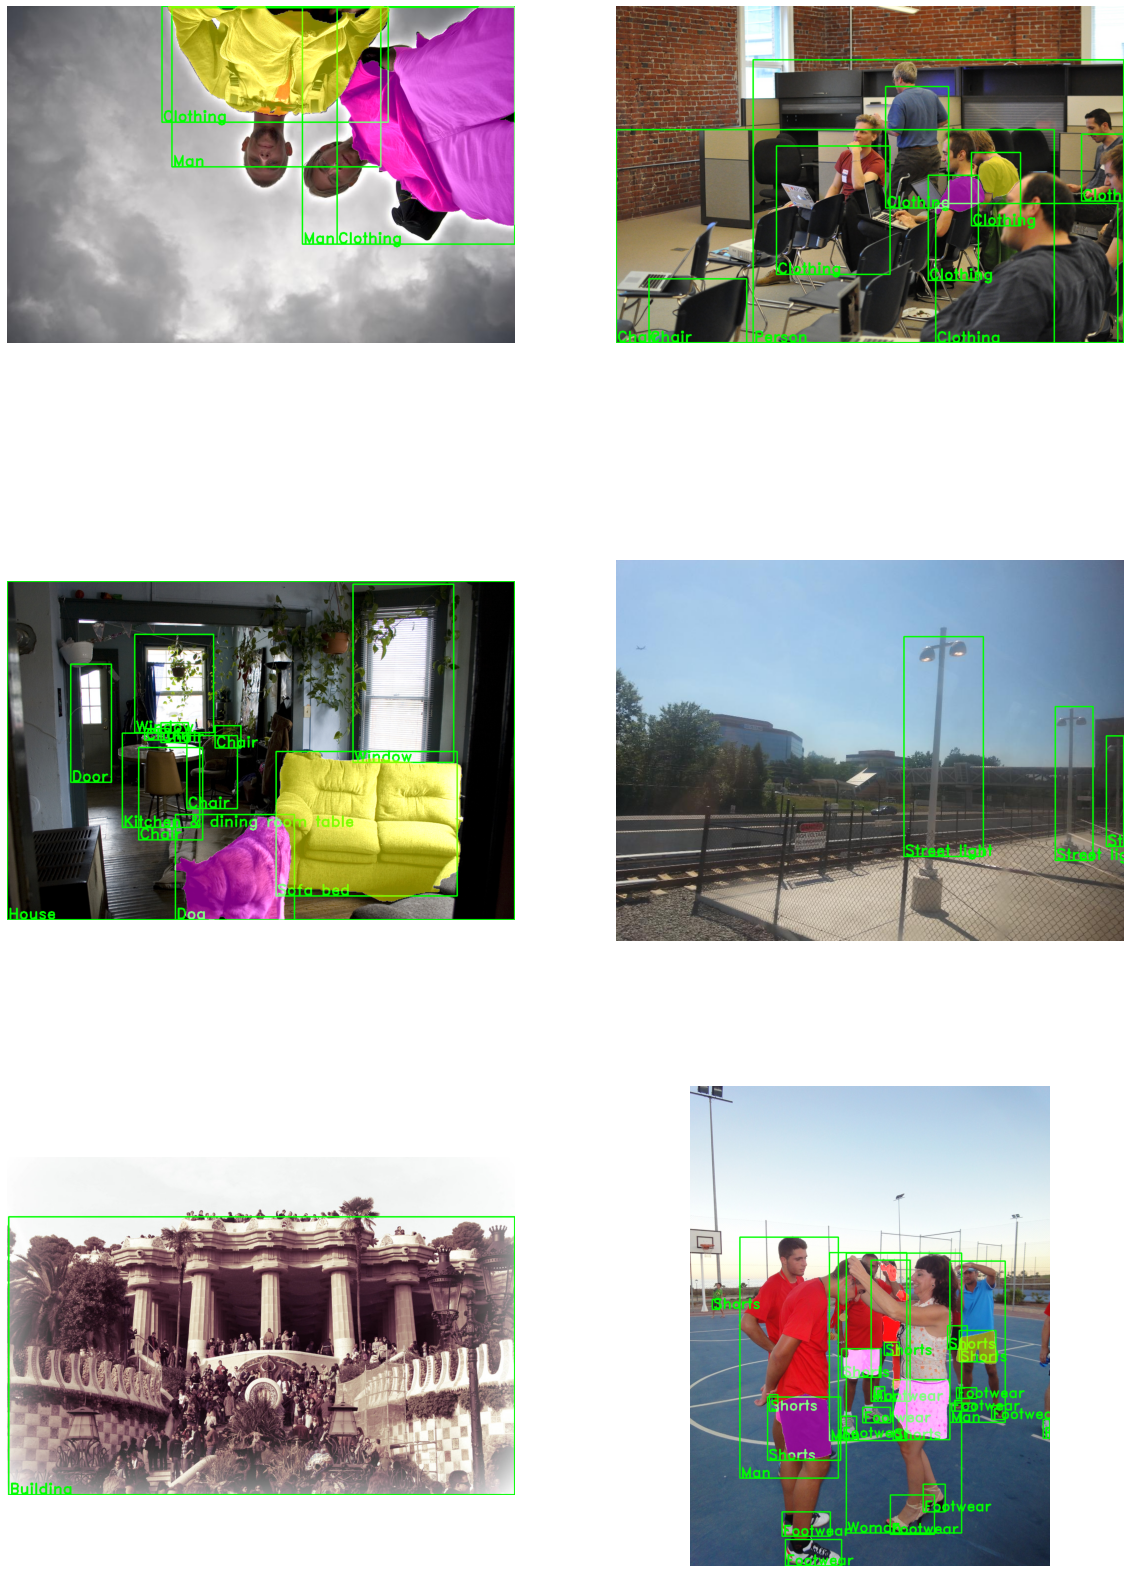

In [4]:
# Annotate and plot
cols, rows  = 3, 2
plt.figure(figsize=(20,30))


for i,im_file in enumerate(im_list[9:15], start=1):
    df = boxes_df.query('ImageID == @im_file.stem').copy()
    img = cv2.imread(str(im_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Add boxes
    h0, w0 = img.shape[:2]
    coords = ['XMin', 'YMin', 'XMax', 'YMax']
    df[coords] = (df[coords].to_numpy() * np.tile([w0, h0], 2)).astype(int)

    for tup in df.itertuples():
        cv2.rectangle(img, (tup.XMin, tup.YMin), (tup.XMax, tup.YMax),
                      color=(0,255,0), thickness=2)
        cv2.putText(img, tup.Label, (tup.XMin+2, tup.YMax-2),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=1, color=(0,255,0), thickness=2)
    
    # Add segmentation masks
    mask_files = [m for m in mask_list if im_file.stem in m.stem]    
    mask_master = np.zeros_like(img)
    np.random.seed(10)
    for m in mask_files:
        mask = cv2.imread(str(m))
        mask = cv2.resize(mask, (w0,h0), interpolation = cv2.INTER_AREA)
        color = np.random.choice([0,255], size=3)
        mask[np.where((mask==[255, 255, 255]).all(axis=2))] = color
        mask_master = cv2.add(mask_master, mask)
    img = cv2.addWeighted(img,1, mask_master,0.5, 0)    
    
    plt.subplot(cols, rows, i)    
    plt.axis('off')
    plt.imshow(img)

plt.show()

# Oject Detection Demo
Reading instance-segmentation data

In [5]:
 urls = pd.read_csv(data_dir/"image_ids_and_rotation.csv", 
                   usecols=['ImageID', 'OriginalURL'])

In [6]:
classes = np.loadtxt(data_dir/"openimages.names", dtype=np.str, delimiter="\n")
net = cv2.dnn.readNet(str(data_dir/"yolov3-openimages.weights"), str(data_dir/"yolov3-openimages.cfg"))

layer_names = net.getLayerNames()
outputlayers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [7]:
%%time

from skimage import io

im_url = urls.loc[urls.ImageID==im_list[11].stem, 'OriginalURL'].squeeze()
img = io.imread(im_url)

height,width,channels = img.shape

# Make a blob array and run it through the network
blob = cv2.dnn.blobFromImage(img,0.00392,(416,416),(0,0,0),True,crop=False)
net.setInput(blob)
outs = net.forward(outputlayers)

# Get confidence scores and objects
class_ids=[]
confidences=[]
boxes=[]
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.2:   # threshold
            print(confidence)
            center_x= int(detection[0]*width)
            center_y= int(detection[1]*height)
            w = int(detection[2]*width)
            h = int(detection[3]*height)
            x=int(center_x - w/2)
            y=int(center_y - h/2)
            boxes.append([x,y,w,h]) #put all rectangle areas
            confidences.append(float(confidence)) #how confidence was that object detected and show that percentage
            class_ids.append(class_id) #name of the object tha was detected
            
# Non-max suppression
indexes = cv2.dnn.NMSBoxes(boxes,confidences,0.4,0.6)
print(indexes, boxes, class_ids)

0.3348308
0.36682394
0.6396205
0.3560101
[[2]] [[392, 24, 3218, 2614], [1627, 1306, 1907, 1171], [1163, 1711, 1027, 938], [985, 1218, 499, 661]] [461, 465, 560, 465]
CPU times: user 5.35 s, sys: 666 ms, total: 6.02 s
Wall time: 5.86 s


<Figure size 432x288 with 0 Axes>

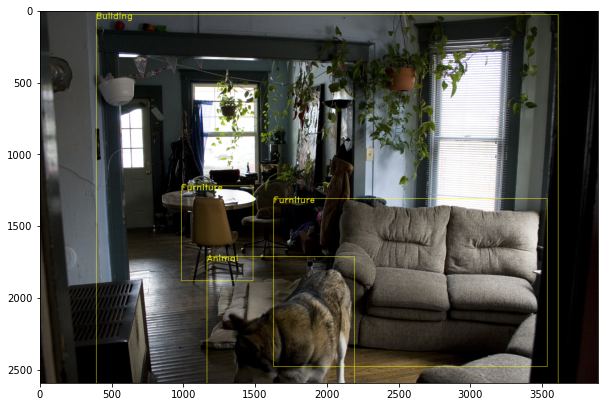

In [8]:
font = cv2.FONT_HERSHEY_DUPLEX
for i in range(len(boxes)):
#     if i in indexes:
        x,y,w,h = boxes[i]
        label = str(classes[class_ids[i]])
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,0), 2)
        cv2.putText(img, label, (x,y+30), font, 2, (255,255,0), 2)
        
plt.clf()
plt.figure(figsize=(10,15))
plt.imshow(img)

Labels Counts per image

In [9]:
annotations = boxes_df.groupby('ImageID').agg(
                        box_count=('LabelName', 'size'),
                        box_unique=('LabelName', 'nunique')
                        )

pd.options.display.float_format = '{:,.1f}'.format
annotations.describe()

box_count  box_unique
count      255.0       255.0
mean         9.3         2.5
std         13.4         1.6
min          1.0         1.0
25%          2.0         1.0
50%          5.0         2.0
75%         10.5         3.0
max        103.0         9.0

In [10]:
all = annotations.hvplot.hist('box_count', width=600, bins=30)
unique = annotations.hvplot.hist('box_unique', width=600)
(all + unique).cols(1)

:Layout
   .Histogram.I  :Histogram   [box_count]   (box_count_count)
   .Histogram.II :Histogram   [box_unique]   (box_unique_count)

In [11]:
onepct = annotations.box_count.quantile(0.99)
annotations.query('box_count < @onepct').box_count.value_counts(normalize=True) \
    .sort_index().hvplot.bar(xticks=list(range(0,60,10)), width=600,
                            line_alpha=0, xlabel='objects per image',
                            ylabel='fraction of images')

:Bars   [index]   (box_count)

ImageID           Label     
fe7c6f7d298893da  Skyscraper      1
                  Window        102
Name: LabelName, dtype: int64


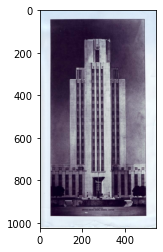

In [12]:
print(boxes_df.loc[boxes_df.ImageID=="fe7c6f7d298893da"] \
         .groupby(['ImageID', 'Label'])['LabelName'].size()
     )

im_file = "../input/excerpt-from-openimages-2020-train/train_00_part/fe7c6f7d298893da.jpg"
im = cv2.imread(im_file)
plt.imshow(im)

Reading Dataset for RVC-2020

In [13]:
from PIL import Image
from dask import bag, diagnostics


def faster_get_dims(file):
    dims = Image.open(file).size
    return dims

dfile_list = glob.glob('../input/open-images-object-detection-rvc-2020/test/*.jpg')
print(f"Getting dimensions for {len(dfile_list)} files.")

# parallelize
dfile_bag = bag.from_sequence(dfile_list).map(faster_get_dims)
with diagnostics.ProgressBar():
    dims_list = dfile_bag.compute()

Getting dimensions for 99999 files.
[########################################] | 100% Completed |  1min 32.4s


In [14]:
sizes = pd.DataFrame(dims_list, columns=['width', 'height'])
counts = sizes.groupby(['width', 'height']).agg(count=('width', 'size')).reset_index()

In [15]:
plot_opts = dict(xlim=(0,1200), 
                 ylim=(0,1200), 
                 grid=True, 
                 xticks=[250, 682, 768, 1024], 
                 yticks=[250, 682, 768, 1024], 
                 height=500, 
                 width=550
                 )

style_opts = dict(scaling_factor=0.2,
                  line_alpha=1,
                  fill_alpha=0.1
                  )

counts.hvplot.scatter(x='width', y='height', size='count', **plot_opts) \
             .options(**style_opts)

:Scatter   [width]   (height,count)

Distributions of Object labels

In [16]:
train_labels = boxes_df[['ImageID', 'LabelName']].merge(labels, how='left', on='LabelName')
train_labels.Label.value_counts(normalize=True)[:45] \
            .hvplot.bar(width=650, height=350, rot=60, line_alpha=0,
                        title='Label Frequencies',
                        ylabel='fraction of all objects')

:Bars   [index]   (Label)

In [17]:
relations = pd.read_csv(data_dir/'oidv6-relationship-triplets.csv')
relations = relations.merge(labels, how='left', left_on='LabelName1', right_on='LabelName') \
                     .merge(labels, how='left', left_on='LabelName2', right_on='LabelName',
                            suffixes=['1', '2']) \
                     .loc[:, ['Label1', 'RelationshipLabel', 'Label2']] \
                     .dropna() \
                     .sort_values('RelationshipLabel') \
                     .reset_index(drop=True)

Mapping the entire network is quite complex. Here's a map for only two entities, boy and girl, and all the things to which they connect in the images.

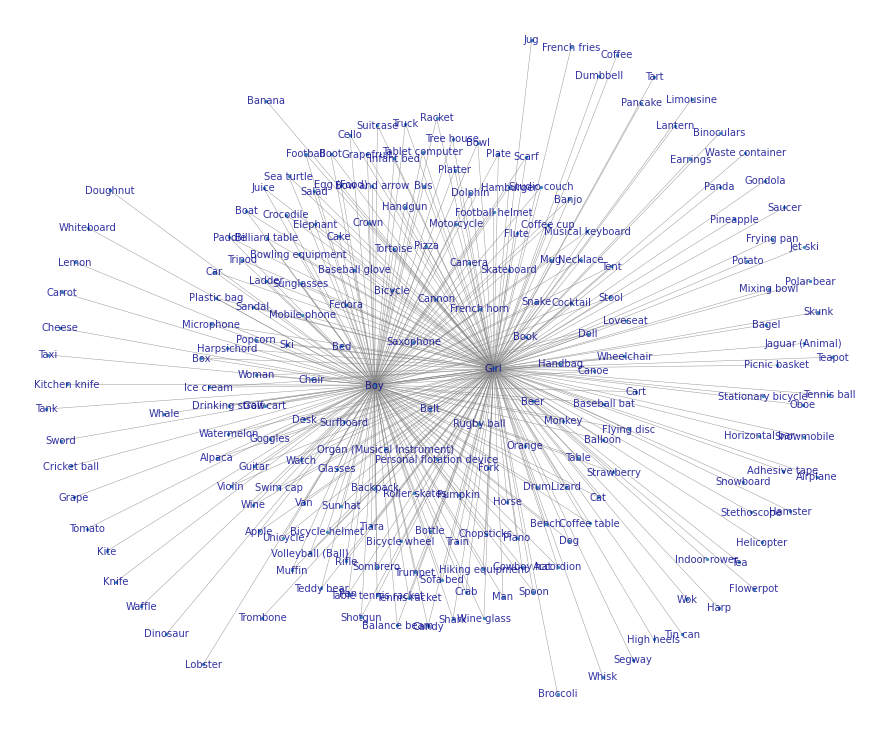

In [18]:
import networkx as nx

kids = relations.query('Label1=="Girl" or Label1=="Boy"')
G = nx.from_pandas_edgelist(kids, 'Label1', 'Label2', 'RelationshipLabel')


graph_opts = dict(arrows=False,
                  node_size=5,
                  width=0.5,
                  alpha=0.8,
                  font_size=10,
                  font_color='darkblue',
                  edge_color='gray'
                
                 )

fig= plt.figure(figsize=(12,10))
nx.draw_spring(G, with_labels=True, **graph_opts)